In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
credit = pd.read_csv('../data/credit_applications.csv')
customers = pd.read_csv('../data/customers.csv')
df = pd.merge(credit, customers, on=['client_nr', 'yearmonth'], how='outer')  # You can change 'outer' to 'inner', 'left', or 'right' as needed


In [3]:
df.drop(columns=['Unnamed: 0_y',  'Unnamed: 0_x'], inplace=True)

In [4]:
df['year'] = df['yearmonth'] // 100
df['month'] = df['yearmonth'] % 100


In [5]:
for col in ['total_nr_trx', 'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx']:
    df[col] = np.log1p(df[col])  # Use log(1+x) to avoid log(0)

for col in ['volume_debit_trx', 'volume_credit_trx', 'max_balance']:
    df[col] = df[col].clip(upper=df[col].quantile(0.99))


df.transaction_balance_ratio = df.total_nr_trx / df.max_balance
df.debit_credit_ratio = df.nr_debit_trx / df.nr_credit_trx

# Create a binary flag for negative balances
df['min_balance_negative_flag'] = (df['min_balance'] < 0).astype(int)

# Take the absolute value for transformation
df['min_balance_abs'] = df['min_balance'].abs()

# Apply log1p transformation to the absolute value
df['min_balance_abs'] = np.log1p(df['min_balance_abs'])


# Create a binary flag for negative balances
df['max_balance_negative_flag'] = (df['max_balance'] < 0).astype(int)

# Take the absolute value for transformation
df['max_balance_abs'] = df['max_balance'].abs()

# Apply log1p transformation to the absolute value
df['max_balance_abs'] = np.log1p(df['max_balance_abs'])


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/550620337.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.transaction_balance_ratio = df.total_nr_trx / df.max_balance
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/550620337.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.debit_credit_ratio = df.nr_debit_trx / df.nr_credit_trx


In [6]:
# Identify customers with all CRG missing
clients_with_all_na_crg = df.groupby('client_nr')['CRG'].apply(lambda x: x.isna().all()).reset_index()
clients_with_all_na_crg = clients_with_all_na_crg[clients_with_all_na_crg['CRG'] == True]['client_nr']

# For these customers, impute CRG based on the median CRG of customers with similar 'volume_debit_trx'
median_crg_by_volume = df.groupby('client_nr')['volume_debit_trx'].median()

# Calculate the global median CRG for customers with valid CRG
global_crg_median = df['CRG'].median()

# Impute missing CRG values for customers with all NaNs
for client in clients_with_all_na_crg:
    # Find median volume_debit_trx for this customer
    median_volume = median_crg_by_volume[client]

    # Impute CRG based on global median or other features
    df.loc[df['client_nr'] == client, 'CRG'] = global_crg_median


In [7]:
# Interaction Features with CRG
df['CRG_total_nr_trx'] = df['CRG'] * df['total_nr_trx']
df['CRG_nr_debit_trx'] = df['CRG'] * df['nr_debit_trx']
df['CRG_nr_credit_trx'] = df['CRG'] * df['nr_credit_trx']
df['CRG_volume_debit_trx'] = df['CRG'] * df['volume_debit_trx']
df['CRG_volume_credit_trx'] = df['CRG'] * df['volume_credit_trx']

# Binning CRG into categories (example: quartiles)
# Dynamically adjust labels based on the number of bins created
labels = ['Low', 'Medium-Low', 'Medium-High', 'High']  # Define initial labels
df['CRG_binned'] = pd.qcut(
    df['CRG'], 
    q=5,  # Initial number of quantiles
    labels=labels[:4],  # Ensure labels are one fewer than the resulting bins
    duplicates='drop'  # Drop duplicate edges
)


# Optional: Convert the binned CRG feature into dummy variables
df = pd.get_dummies(df, columns=['CRG_binned'], drop_first=False)


In [8]:
def create_features(data, group_col, time_col, rolling_features, cumulative_features, window=3):
    """
    Creates rolling window features, recency, and cumulative features for the dataset.

    Args:
    - data (DataFrame): Input dataset.
    - group_col (str): Column for grouping (e.g., client_nr).
    - time_col (str): Column representing time (e.g., yearmonth).
    - rolling_features (list): List of features to compute rolling statistics.
    - cumulative_features (list): List of features to compute cumulative sums.
    - window (int): Size of the rolling window.

    Returns:
    - DataFrame with new rolling, recency, and cumulative features.
    """
    data = data.copy()

    # Ensure data is sorted for rolling and cumulative computations
    data = data.sort_values(by=[group_col, time_col])

    # Rolling window features
    for feature in rolling_features:
        data[f'{feature}_rolling_mean_{window}'] = data.groupby(group_col)[feature].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        data[f'{feature}_rolling_std_{window}'] = data.groupby(group_col)[feature].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        data[f'{feature}_rolling_sum_{window}'] = data.groupby(group_col)[feature].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        )

    # Recency feature: Check if there was a credit application in the past 6 months (excluding the current month)
    def calculate_past_6_months_flag_excluding_current(x):
        return x.shift().rolling(window=6, min_periods=1).max()

    data['recency_6_months'] = data.groupby(group_col)['credit_application'].transform(
        calculate_past_6_months_flag_excluding_current
    )

    # Number of credit applications in the past 6 months (excluding the current month)
    def calculate_past_6_months_count_excluding_current(x):
        return x.shift().rolling(window=6, min_periods=1).sum()

    data['nr_applications_6_months'] = data.groupby(group_col)['nr_credit_applications'].transform(
        calculate_past_6_months_count_excluding_current
    )

    # Handle missing values with backward fill and median replacement
    data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))
    data.fillna(data.median(), inplace=True)
    data.reset_index(drop=True, inplace=True)

    return data

# Example usage
rolling_features = ['nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'min_balance',
                    'max_balance', 'CRG', 'total_nr_trx']
cumulative_features = ['nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'total_nr_trx']

processed_data = create_features(
    data=df,
    group_col='client_nr',
    time_col='yearmonth',
    rolling_features=rolling_features,
    cumulative_features=cumulative_features,
    window=3
)



/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/2161067413.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/2161067413.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))


In [9]:
processed_data[processed_data.client_nr == 974]['max_balance']

29572   -248520614.0
29573            0.0
29574         2500.0
29575            0.0
Name: max_balance, dtype: float64

In [10]:
def add_lagged_and_statistical_features(data, group_col, features):
    """
    Adds lagged features (1 to 6 months) and min, max, mean, and std for the last 2 to 6 months.

    Args:
    - data (DataFrame): Input dataset.
    - group_col (str): Column for grouping (e.g., client_nr).
    - features (list): List of features to generate lagged and statistical features.

    Returns:
    - DataFrame with lagged and statistical features added.
    """
    data = data.copy()

    # Lagged features from 1 to 6 months
    for lag in range(1, 7):
        for feature in features:
            data[f'{feature}_lag_{lag}'] = data.groupby(group_col)[feature].shift(lag)

    # Min, Max, Mean, and Std for the previous 2, 3, 4, 5, 6 months
    for window_size in range(2, 7):
        for feature in features:
            data[f'{feature}_min_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).min()
            )
            data[f'{feature}_max_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).max()
            )
            data[f'{feature}_mean_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).mean()
            )
            data[f'{feature}_std_last_{window_size}'] = data.groupby(group_col)[feature].transform(
                lambda x: x.shift().rolling(window=window_size, min_periods=1).std()
            )

    # Handle missing values with backward fill and median replacement
    data = data.groupby(group_col).apply(lambda group: group.fillna(method='bfill'))
    data.fillna(data.median(), inplace=True)
    data.reset_index(drop=True, inplace=True)

    return data

features = ['nr_debit_trx', 'nr_credit_trx', 'volume_debit_trx', 'volume_credit_trx', 'min_balance',
            'max_balance', 'CRG', 'total_nr_trx', 'min_balance', 'max_balance']

processed_data = add_lagged_and_statistical_features(
    data=df,
    group_col='client_nr',
    features=features
)


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/2642226675.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{feature}_max_last_{window_size}'] = data.groupby(group_col)[feature].transform(
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/2642226675.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{feature}_mean_last_{window_size}'] = data.groupby(group_col)[feature].transform(
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7661/2642226675.py:32: PerformanceWarning:

In [6]:
processed_data.shape

(29996, 220)

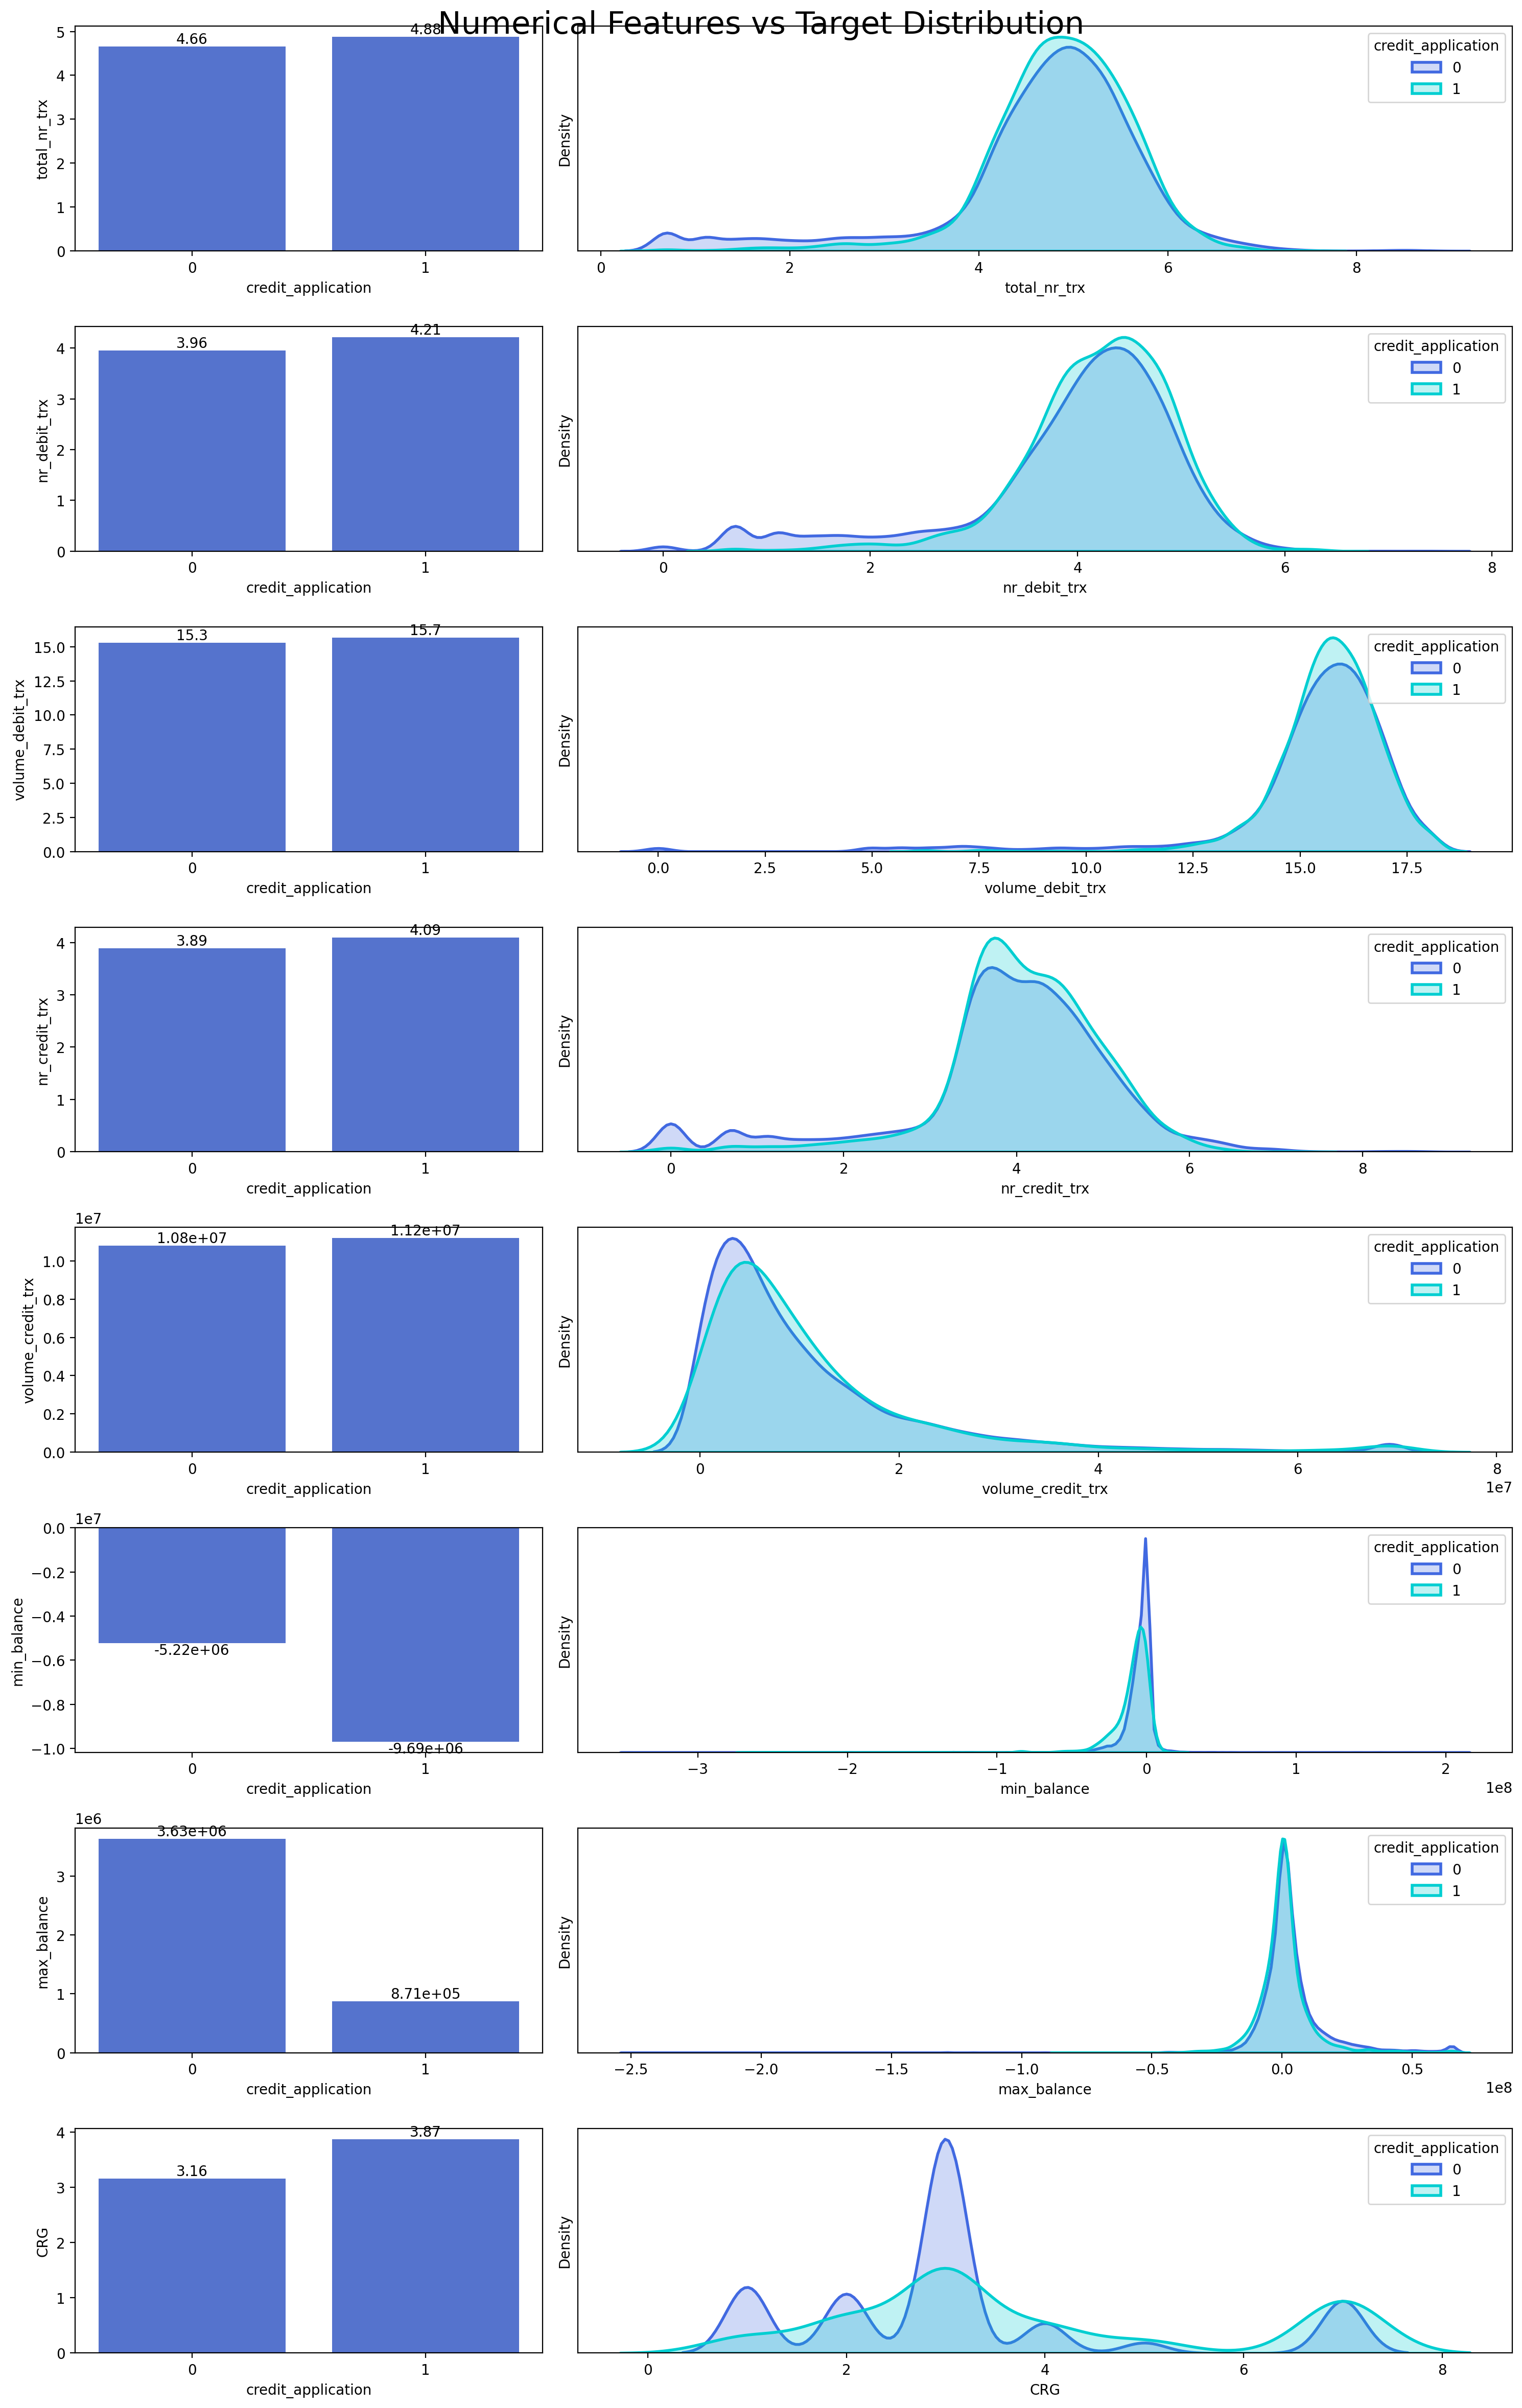

In [85]:
# Specify the numerical features to analyze
Num_Features = [
    'total_nr_trx', 'nr_debit_trx', 'volume_debit_trx',
    'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance', 'CRG',
   
]

# Define a target variable, if applicable (replace with your actual target column if exists)
Target = 'credit_application'  # Replace with relevant column name for binary target if applicable

# Set the seaborn palette
sns.set_palette(['royalblue', 'darkturquoise'])

# Create subplots
fig, ax = plt.subplots(len(Num_Features), 2, figsize=(15, len(Num_Features) * 3), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i, col in enumerate(Num_Features):
    # Barplot for numerical features against the target
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i, 0], errorbar=None)
    
    # KDE plot for numerical feature distributions grouped by target
    sns.kdeplot(data=df[df[Target] == 0], x=col, fill=True, linewidth=2, ax=ax[i, 1], label='0')
    sns.kdeplot(data=df[df[Target] == 1], x=col, fill=True, linewidth=2, ax=ax[i, 1], label='1')
    
    # Clean up the right-hand plot
    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title=Target, loc='upper right')
    
    # Add bar sizes to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='%.3g')

# Add a title and adjust layout
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

In [46]:
df.isna().sum().sum()

5537

In [11]:
processed_data.drop(columns=['nr_credit_applications'], inplace=True)

In [80]:
df.drop(columns=['nr_credit_applications'], inplace=True)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score
import xgboost as xgb
import catboost as cb
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer



# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],  # Increase the range for boosting rounds
    'learning_rate': [0.05, 0.1, 0.2],  # Lower learning rates for better performance
    'max_depth': [5, 10, 15],  # Reduce depth for better generalization
    'reg_alpha': [0, 1, 5],  # Expand range of L1 regularization
    'reg_lambda': [0, 1, 5],  # Expand range of L2 regularization
}


clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]

X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']

model = LGBMClassifier(
    random_state=42,
    class_weight='balanced'  # Automatically balance class weights
)




# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1 score
    cv=2,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

model.fit(X_train, y_train)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")

# Evaluate precision on the test set
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred, zero_division=1)
print(f"Test Precision: {precision}")


[LightGBM] [Info] Number of positive: 1584, number of negative: 22449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50435
[LightGBM] [Info] Number of data points in the train set: 24033, number of used features: 228
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

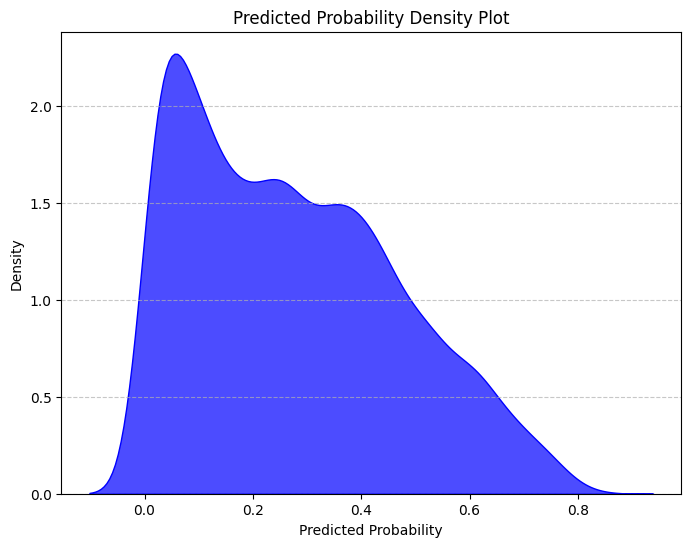

In [13]:
import seaborn as sns

y_pred_proba = model.predict_proba(X_test)[:, 1]
# Plot density of predicted probabilities
plt.figure(figsize=(8, 6))
sns.kdeplot(y_pred_proba, fill=True, color='blue', alpha=0.7)
plt.title('Predicted Probability Density Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


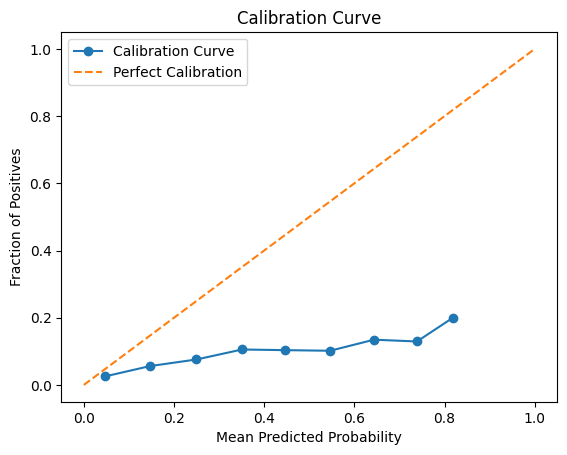

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()


In [113]:
print(best_model)

LGBMClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
               random_state=42, reg_alpha=0, reg_lambda=0)


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[LightGBM] [Info] Number of positive: 353, number of negative: 4417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49897
[LightGBM] [Info] Number of data points in the train set: 4770, number of used features: 228
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 353, number of negative: 4417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49939
[LightGBM] [Info] Number of data points in the train set: 4770, number of used features: 228
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info

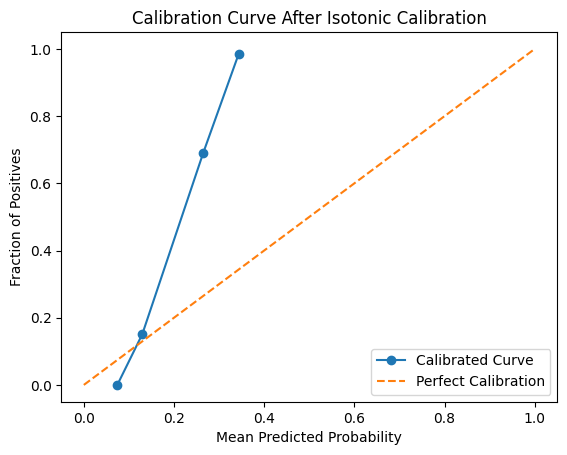

In [15]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap the existing model with calibration
# Wrap the model with calibration
calibrated_model = CalibratedClassifierCV(base_estimator=model)
calibrated_model.fit(X_test, y_test)

# Predict calibrated probabilities
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Plot the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve After Isotonic Calibration')
plt.show()


In [94]:
y_pred = best_model.predict(X_test)

print(y_pred.sum())

2044


In [24]:
from sklearn.metrics import classification_report

# Predict calibrated probabilities
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Adjust the prediction threshold
threshold = 0.5  # You can change this value if needed
y_pred = (y_pred_proba_calibrated > threshold).astype(int)

# Print the number of positive predictions

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5522
           1       0.00      0.00      0.00       441

    accuracy                           0.93      5963
   macro avg       0.46      0.50      0.48      5963
weighted avg       0.86      0.93      0.89      5963



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [31]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, precision_score, f1_score
from sklearn.impute import SimpleImputer
import pandas as pd
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import xgboost as xgb
# Impute missing values with median
imputer = SimpleImputer(strategy='median')
df2 = pd.DataFrame(imputer.fit_transform(processed_data), columns=processed_data.columns)

# Define parameter grid for LightGBM
param_grid = {
    'n_estimators': [50, 100],  # Reduced range to speed up
    'learning_rate': [0.01, 0.1],  # Focused on commonly used values
    'num_leaves': [31, 50],  # Limited options to speed up search
    'max_depth': [-1, 10],  # Reduced complexity
    'reg_alpha': [1, 10],  # Narrower range
    'reg_lambda': [1, 10],  

}

param_xgb = {
    "objective": ["binary:logistic"],  # For binary classification
    "max_depth": [3, 5, 7],        # Depth of the trees
    "scale_pos_weight": [10,50], # Handle class imbalance
    "eta": [0.01, 0.05],     # Learning rate
    "min_child_weight": [1, 3, 5],     # Minimum sum of instance weight needed in a child
    "lambda": [ 1, 50],              # L2 regularization term on weights
}


# Split the clients into train and test sets
clients = df2['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = df2[df2['client_nr'].isin(train_clients)]
test_data = df2[df2['client_nr'].isin(test_clients)]

# Define features and target
X_train = train_data.drop(columns=['credit_application', 'client_nr', 'yearmonth'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application', 'client_nr', 'yearmonth'])
y_test = test_data['credit_application']





# Initialize LightGBM model with class weights and early stopping
model = LGBMClassifier(
    random_state=42,
    class_weight='balanced'  # Automatically balance class weights
)

# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric=[ 'logloss'],  # Add custom precision metric during evaluation
#     scale_pos_weight=15,     # Adjust this based on class imbalance
# )

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1 score
    cv=2,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best F1 Score (CV): {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")

# Evaluate precision, recall, and F1-score on the test set
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"Test Precision: {precision}")
print(f"Test F1 Score: {f1}")


Fitting 2 folds for each of 64 candidates, totalling 128 fits
[LightGBM] [Info] Number of positive: 792, number of negative: 11224
[LightGBM] [Info] Number of positive: 792, number of negative: 11225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of positive: 792, number of negative: 11224
[LightGBM] [Info] Total Bins 48052
[LightGBM] [Info] Number of data points in the train set: 12016, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 792, number of negative: 11224
[LightGBM] [Info] Number of positive: 792, number of negative: 11225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if m

In [41]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
#adjust the prediction threshold
y_pred = (y_pred_proba > 0.1).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.11      0.19      5522
         1.0       0.08      0.99      0.15       441

    accuracy                           0.17      5963
   macro avg       0.54      0.55      0.17      5963
weighted avg       0.92      0.17      0.19      5963



In [29]:
from sklearn.utils import check_X_y, check_array
from sklearn.utils.multiclass import unique_labels

class HeDExDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def _hellinger_distance(self, p1, p2):
        """
        Compute the Hellinger Distance between two probability distributions.
        """
        return np.sqrt(0.5 * np.sum((np.sqrt(p1) - np.sqrt(p2)) ** 2))

    def _split_criterion(self, X, y):
        """
        Determine the best split based on Hellinger Distance.
        """
        best_feature = None
        best_threshold = None
        best_distance = float('inf')

        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue

                left_counts = np.bincount(y[left_mask], minlength=self.n_classes_)
                right_counts = np.bincount(y[right_mask], minlength=self.n_classes_)

                left_prob = left_counts / np.sum(left_counts)
                right_prob = right_counts / np.sum(right_counts)

                distance = self._hellinger_distance(left_prob, right_prob)

                if distance < best_distance:
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_distance = distance

        return best_feature, best_threshold, best_distance

    def _build_tree(self, X, y, depth):
        """
        Recursively build the tree using Hellinger Distance as the criterion.
        """
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return {
                "leaf": True,
                "class": np.argmax(np.bincount(y))
            }

        feature, threshold, distance = self._split_criterion(X, y)

        if feature is None:
            return {
                "leaf": True,
                "class": np.argmax(np.bincount(y))
            }

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            "leaf": False,
            "feature": feature,
            "threshold": threshold,
            "left": self._build_tree(X[left_mask], y[left_mask], depth + 1),
            "right": self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        """
        Fit the HeDEx Decision Tree to the data.
        """
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.tree_ = self._build_tree(X, y, depth=0)
        return self

    def _predict_single(self, x, node):
        """
        Predict for a single sample recursively.
        """
        if node["leaf"]:
            return node["class"]

        if x[node["feature"]] <= node["threshold"]:
            return self._predict_single(x, node["left"])
        else:
            return self._predict_single(x, node["right"])

    def predict(self, X):
        """
        Predict class labels for the input samples.
        """
        X = check_array(X)
        return np.array([self._predict_single(x, self.tree_) for x in X])


In [30]:
# Import necessary utilities
from sklearn.metrics import accuracy_score

# Initialize the HeDExDecisionTree
hedex_tree = HeDExDecisionTree(max_depth=5, min_samples_split=10)

# Fit the HeDEx Decision Tree to the training data
hedex_tree.fit(X_train.values, y_train.values)

# Predict on the test set
y_pred_hedex = hedex_tree.predict(X_test.values)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred_hedex)
print(f"HeDEx Decision Tree Test Accuracy: {accuracy:.4f}")


KeyboardInterrupt: 

In [19]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, precision_score
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold

# Isolation Forest for outlier detection
df.fillna(df.median(), inplace=True)
iso_forest = IsolationForest(random_state=42, contamination=0.1)
df['outlier_flag'] = iso_forest.fit_predict(df.drop(columns=['credit_application', 'client_nr']))

# Separate outliers and non-outliers
outlier_clients = df.loc[df['outlier_flag'] == -1, 'client_nr'].unique()

# Separate data based on outlier clients
outliers_data = df[df['client_nr'].isin(outlier_clients)]
non_outliers_data = df[~df['client_nr'].isin(outlier_clients)]

# Define parameter grid
param_grid = {
    'n_estimators': [5, 200],
    'learning_rate': [ 0.2, 0.3],
    'max_depth': [ 7, 15],
    'subsample': [0.8, 1.0],
    'reg_alpha': [1, 10],
    'reg_lambda': [1, 10],
}

# Helper function to fit a model for a given dataset
def fit_model(data, param_grid, label_col='credit_application', cv=2):
    clients = data['client_nr'].unique()
    train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)
    
    train_data = data[data['client_nr'].isin(train_clients)]
    test_data = data[data['client_nr'].isin(test_clients)]
    
    X_train = train_data.drop(columns=[label_col, 'outlier_flag'])
    y_train = train_data[label_col]
    X_test = test_data.drop(columns=[label_col, 'outlier_flag'])
    y_test = test_data[label_col]


    # Fit the VarianceThreshold on the training set
    selector = VarianceThreshold(threshold=0.05)  # Adjust threshold as needed
    X_train_filtered = selector.fit_transform(X_train)

    # Transform the test set using the same selector
    X_test_filtered = selector.transform(X_test)


    model = LGBMClassifier(random_state=42, class_weight='balanced')

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Best model and evaluation
    best_model = grid_search.best_estimator_
    print(f"Best F1 Score (Train): {grid_search.best_score_}")

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Test AUC: {auc}")

    y_pred = best_model.predict(X_test)
    precision = precision_score(y_test, y_pred, zero_division=1)
    print(f"Test Precision: {precision}")

    #classification report
    y_pred = best_model.predict(X_test)
    #adjust the prediction threshold

    print(classification_report(y_test, y_pred))

    return best_model

# Fit models for non-outliers and outliers
print("Fitting model for non-outliers...")
non_outliers_model = fit_model(non_outliers_data, param_grid)



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Fitting model for non-outliers...
Fitting 2 folds for each of 64 candidates, totalling 128 fits
[LightGBM] [Info] Number of positive: 516, number of negative: 7434
[LightGBM] [Info] Number of positive: 516, number of negative: 7434
[LightGBM] [Info] Number of positive: 516, number of negative: 7434
[LightGBM] [Info] Number of positive: 515, number of negative: 7435
[LightGBM] [Info] Number of positive: 516, number of negative: 7434
[LightGBM] [Info] Number of positive: 515, number of negative: 7435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_col_wise=true` 

In [20]:
print("\nFitting model for outliers...")
outliers_model = fit_model(outliers_data, param_grid)



Fitting model for outliers...
Fitting 2 folds for each of 64 candidates, totalling 128 fits
[LightGBM] [Info] Number of positive: 295, number of negative: 3741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1980
[LightGBM] [Info] Number of data points in the train set: 4036, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 295, number of negative: 3741
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 4036, number of used features: 12

In [17]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



In [9]:
processed_data.drop(columns=['nr_credit_applications'], inplace=True)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import catboost as cb

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Train the model with balanced data
from imblearn.under_sampling import RandomUnderSampler
clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]


X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']

# Apply undersampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)


model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

)



grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_train, y_train)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,...,max_balance_mean_last_6,max_balance_std_last_6,CRG_min_last_6,CRG_max_last_6,CRG_mean_last_6,CRG_std_last_6,total_nr_trx_min_last_6,total_nr_trx_max_last_6,total_nr_trx_mean_last_6,total_nr_trx_std_last_6
0,1,201401,97,50,6527929,47,7454863,-7914288,25110651,1.0,...,2.511065e+07,5.232590e+04,1.0,1.0,1.0,0.0,97.0,97.0,97.000000,6.363961
1,1,201402,88,59,3475918,29,1895848,-8448513,25036651,1.0,...,2.511065e+07,5.232590e+04,1.0,1.0,1.0,0.0,97.0,97.0,97.000000,6.363961
2,1,201403,96,62,31316405,34,20083583,-10347650,18020151,1.0,...,2.507365e+07,5.232590e+04,1.0,1.0,1.0,0.0,88.0,97.0,92.500000,6.363961
3,1,201404,83,53,18669967,30,1091295,-15385039,13318200,1.0,...,2.272248e+07,4.072508e+06,1.0,1.0,1.0,0.0,88.0,97.0,93.666667,4.932883
4,1,201405,94,54,2893905,40,2034075,-15682170,2350000,1.0,...,2.037141e+07,5.759082e+06,1.0,1.0,1.0,0.0,83.0,97.0,91.000000,6.683313


In [15]:
#if we wan to apply pca and random forrest

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]


X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for compatibility with column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


# Original model
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Performance with original features:")
print(classification_report(y_test, y_pred))

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Model with PCA-transformed features
model_pca = RandomForestClassifier(random_state=42, class_weight='balanced')
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
print("Performance with PCA features:")
print(classification_report(y_test, y_pred_pca))


Performance with original features:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5522
           1       0.00      0.00      0.00       441

    accuracy                           0.93      5963
   macro avg       0.46      0.50      0.48      5963
weighted avg       0.86      0.93      0.89      5963



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Performance with PCA features:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5522
           1       0.00      0.00      0.00       441

    accuracy                           0.93      5963
   macro avg       0.46      0.50      0.48      5963
weighted avg       0.86      0.93      0.89      5963



/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE


# Define parameter grids
catboost_param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

adaboost_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Train the model with balanced data
clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]

X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']

# Apply undersampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Apply SMOTE for oversampling
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# CatBoost Classifier
def test_catboost():
    # Update CatBoost Classifier with Class Weights
    model = CatBoostClassifier(verbose=0)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=catboost_param_grid,
        cv=3,
        verbose=1,
    )
    grid_search.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    # Adjust Threshold
    threshold = 0.5
    y_pred_adjusted = (y_pred_proba > threshold).astype(int)

    # Evaluate
    print(classification_report(y_test, y_pred_adjusted))



from sklearn.tree import DecisionTreeClassifier



# # AdaBoost Classifier
# def test_adaboost():
#     # Define the base estimator with class weights
#     base_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')

#     # Initialize AdaBoost with the base estimator
#     model = AdaBoostClassifier(base_estimator=base_estimator)

#     # Define the parameter grid
#     adaboost_param_grid = {
#         'n_estimators': [50, 100, 200],
#         'learning_rate': [0.01, 0.1, 1, 10],
#     }

#     # Perform grid search
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=adaboost_param_grid,
#         cv=3,
#         verbose=1,
#     )
#     grid_search.fit(X_train, y_train)
    
#     # Best model and score
#     best_model = grid_search.best_estimator_
#     print(f"Best AdaBoost AUC: {grid_search.best_score_}")

#     # Evaluate on test set
#     y_pred = best_model.predict(X_test)
#     y_pred_proba = best_model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_pred_proba)
#     print(f"Test AUC (AdaBoost): {auc}")

#     # Adjust Threshold
#     threshold = 0.5
#     y_pred_adjusted = (y_pred_proba > threshold).astype(int)

#     # Evaluate
#     print(classification_report(y_test, y_pred_adjusted))

# Run tests
test_catboost()
#test_adaboost()


Fitting 3 folds for each of 486 candidates, totalling 1458 fits


KeyboardInterrupt: 

In [ ]:
## if we seperate train the outliers one and the other ones


from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import pandas as pd

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Train-test split based on unique clients
clients = processed_data['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

train_data = processed_data[processed_data['client_nr'].isin(train_clients)]
test_data = processed_data[processed_data['client_nr'].isin(test_clients)]

X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']

# Outlier detection using Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.01)  # Adjust contamination rate as needed
X_train['outlier'] = iso_forest.fit_predict(X_train)

# Remove full customer data if they have any outliers
outlier_clients = X_train[X_train['outlier'] == -1]['client_nr'].unique()
clean_train_data = train_data[~train_data['client_nr'].isin(outlier_clients)]

X_clean = clean_train_data.drop(columns=['credit_application'])
y_clean = clean_train_data['credit_application']

# Train initial model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss'
    )

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

# grid_search.fit(X_clean, y_clean)

# # Best model and score
# best_model = grid_search.best_estimator_
# print(f"Best AUC (cleaned data): {grid_search.best_score_}")

# # Evaluate on test set
# y_pred_proba_clean = best_model.predict_proba(X_test)[:, 1]
# auc_clean = roc_auc_score(y_test, y_pred_proba_clean)
# print(f"Test AUC (cleaned data): {auc_clean}")

# # Train on original (uncleaned) data for comparison
# grid_search.fit(X_train.drop(columns=['outlier']), y_train)

# # Best model and score for uncleaned data
# best_model_uncleaned = grid_search.best_estimator_
# print(f"Best AUC (uncleaned data): {grid_search.best_score_}")

# # Evaluate on test set (uncleaned data)
# y_pred_proba_uncleaned = best_model_uncleaned.predict_proba(X_test)[:, 1]
# auc_uncleaned = roc_auc_score(y_test, y_pred_proba_uncleaned)
# print(f"Test AUC (uncleaned data): {auc_uncleaned}")


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_7397/3939457757.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['outlier'] = iso_forest.fit_predict(X_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [75]:
df_drop = df.dropna()
df_drop  = df_drop.drop(columns=['nr_credit_applications'])

In [81]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
import pandas as pd

# Define parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Train-test split based on unique clients
clients = df_drop['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

train_data = df_drop[df_drop['client_nr'].isin(train_clients)]
test_data = df_drop[df_drop['client_nr'].isin(test_clients)]

X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']

# Outlier detection using Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.01)  # Adjust contamination rate as needed
X_train['outlier'] = iso_forest.fit_predict(X_train)

# Remove full customer data if they have any outliers
outlier_clients = X_train[X_train['outlier'] == -1]['client_nr'].unique()
clean_train_data = train_data[~train_data['client_nr'].isin(outlier_clients)]

X_clean = clean_train_data.drop(columns=['credit_application'])
y_clean = clean_train_data['credit_application']

# Define AdaBoost model with DecisionTreeClassifier as the base estimator
model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    random_state=42
)

# Grid search on cleaned data
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_clean, y_clean)

# Best model and score
best_model = grid_search.estimator
print(f"Best AUC (cleaned data): {grid_search.best_score_}")

# Evaluate on test set for cleaned data
y_pred_proba_clean = best_model.predict_proba(X_test)[:, 1]
auc_clean = roc_auc_score(y_test, y_pred_proba_clean)
print(f"Test AUC (cleaned data): {auc_clean}")

# Train on original (uncleaned) data for comparison
grid_search.fit(X_train.drop(columns=['outlier']), y_train)

# Best model and score for uncleaned data
best_model_uncleaned = grid_search.estimator
print(f"Best AUC (uncleaned data): {grid_search.best_score_}")

# Evaluate on test set for uncleaned data
y_pred_proba_uncleaned = best_model_uncleaned.predict_proba(X_test)[:, 1]
auc_uncleaned = roc_auc_score(y_test, y_pred_proba_uncleaned)
print(f"Test AUC (uncleaned data): {auc_uncleaned}")


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/Moaze002/.local/share/virtualenvs/CL_prediction-pEDheb0k/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/Moaze002/.local/share

Best AUC (cleaned data): 0.6432509142514055


NotFittedError: This AdaBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [20]:

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Train the model with balanced data
from imblearn.under_sampling import RandomUnderSampler
clients = df_imputed['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = df_imputed[df_imputed['client_nr'].isin(train_clients)]
test_data = df_imputed[df_imputed['client_nr'].isin(test_clients)]


X_train = train_data.drop(columns=['credit_application'])
y_train = train_data['credit_application']
X_test = test_data.drop(columns=['credit_application'])
y_test = test_data['credit_application']

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)


model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

)



grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best AUC: 0.34848484848484845
Test AUC: 0.6109287853738623


In [21]:
# Scale after imputation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

)



grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_train_scaled, y_train_balanced)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")



Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best AUC: 0.3494318181818182
Test AUC: 0.6055616741444857


In [ ]:
# Pivot the data to make it columnar
def pivot_to_columnar(df, target_yearmonth):
    df_pivoted = df.pivot(index='client_nr', columns='yearmonth', values=[
         'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx',
        'volume_credit_trx', 'min_balance', 'max_balance', 'credit_application'
    ])

    # Flatten the multi-level columns
    df_pivoted.columns = ['{}_{}'.format(col[0], col[1]) for col in df_pivoted.columns]
    
    # Reset index
    df_pivoted.reset_index(inplace=True)

    # Ensure all yearmonths are included
    for col_prefix in [ 'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx', 
                       'volume_credit_trx', 'min_balance', 'max_balance', 'credit_application']:
        for yearmonth in range(df['yearmonth'].min(), target_yearmonth + 1):
            col_name = f"{col_prefix}_{yearmonth}"
            if col_name not in df_pivoted:
                df_pivoted[col_name] = 0

    # Create the target column
    df_pivoted['credit_application_target'] = df_pivoted[f'credit_application_{target_yearmonth}']

    # Drop future columns after target
    df_pivoted = df_pivoted[df_pivoted.columns[~df_pivoted.columns.str.endswith(str(target_yearmonth))]]

    return df_pivoted

# Specify the target yearmonth
target_yearmonth = 201608

# Transform the data
transformed_df = pivot_to_columnar(df, target_yearmonth)


/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_2929/2531957398.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivoted[col_name] = 0
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_2929/2531957398.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivoted[col_name] = 0
/var/folders/4p/vxm_gd9s3gg6knrp7ccz49qc0000gn/T/ipykernel_2929/2531957398.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [27]:
transformed_df.head()

,client_nr,nr_debit_trx_201401,nr_debit_trx_201402,nr_debit_trx_201403,nr_debit_trx_201404,nr_debit_trx_201405,nr_debit_trx_201406,nr_debit_trx_201407,nr_debit_trx_201408,nr_debit_trx_201409,...,credit_application_201592,credit_application_201593,credit_application_201594,credit_application_201595,credit_application_201596,credit_application_201597,credit_application_201598,credit_application_201599,credit_application_201600,credit_application_target
0,1,50.0,59.0,62.0,53.0,54.0,51.0,59.0,40.0,49.0,...,0,0,0,0,0,0,0,0,0,0.0
1,2,51.0,47.0,45.0,47.0,32.0,45.0,52.0,46.0,43.0,...,0,0,0,0,0,0,0,0,0,0.0
2,3,58.0,63.0,62.0,76.0,52.0,71.0,80.0,72.0,56.0,...,0,0,0,0,0,0,0,0,0,1.0
3,4,29.0,31.0,32.0,28.0,25.0,29.0,32.0,22.0,29.0,...,0,0,0,0,0,0,0,0,0,0.0
4,5,71.0,61.0,75.0,72.0,32.0,84.0,103.0,68.0,92.0,...,0,0,0,0,0,0,0,0,0,0.0


In [31]:
transformed_df.fillna(0, inplace=True)


In [34]:
from imblearn.under_sampling import RandomUnderSampler, SMOTE
clients = transformed_df['client_nr'].unique()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

# Split the data based on the client split
train_data = transformed_df[transformed_df['client_nr'].isin(train_clients)]
test_data = transformed_df[transformed_df['client_nr'].isin(test_clients)]


X_train = train_data.drop(columns=['credit_application_target'])
y_train = train_data['credit_application_target']

X_test = test_data.drop(columns=['credit_application_target'])
y_test = test_data['credit_application_target']

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

)



grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [70]:
from sklearn.ensemble import IsolationForest

df5 = df_imputed.copy()
df5 = df5.drop(['credit_application'], axis=1)

In [71]:
model=IsolationForest(n_estimators=150, max_samples='auto')
model.fit(df5)

IsolationForest(n_estimators=150)

In [72]:
scores=model.decision_function(df5)
anomaly=model.predict(df5)

df5['scores']=scores
df5['anomaly']=anomaly

df5.head(10)

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,scores,anomaly
0,1.0,201401.0,97.0,50.0,6527929.0,47.0,7454863.0,-7914288.0,25110651.0,1.0,0.038950,1
1,1.0,201402.0,88.0,59.0,3475918.0,29.0,1895848.0,-8448513.0,25036651.0,1.0,0.030369,1
2,1.0,201403.0,96.0,62.0,31316405.0,34.0,20083583.0,-10347650.0,18020151.0,1.0,0.018865,1
3,1.0,201404.0,83.0,53.0,18669967.0,30.0,1091295.0,-15385039.0,13318200.0,1.0,0.017038,1
4,1.0,201405.0,94.0,54.0,2893905.0,40.0,2034075.0,-15682170.0,2350000.0,1.0,0.045369,1
5,1.0,201406.0,74.0,51.0,2083142.0,23.0,3241073.0,-15927514.0,2000000.0,1.0,0.042979,1
6,1.0,201407.0,76.0,59.0,2538771.0,17.0,4564281.0,-15823639.0,2005161.0,1.0,0.047610,1
7,1.0,201408.0,62.0,40.0,2620143.0,22.0,4280647.0,-14468191.0,1750000.0,1.0,0.049347,1
8,1.0,201409.0,90.0,49.0,2500177.0,41.0,8339304.0,-12025540.0,1600000.0,1.0,0.057489,1
9,1.0,201410.0,112.0,68.0,5848714.0,44.0,17013661.0,-7211508.0,7819451.0,1.0,0.056284,1


In [73]:

anomaly = df5.loc[df5['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

Total number of outliers is: 3483


In [85]:
df_imputed.client_nr.value_counts()

client_nr
1.0      32
618.0    32
606.0    32
607.0    32
608.0    32
         ..
996.0     2
971.0     1
377.0     1
256.0     1
433.0     1
Name: count, Length: 992, dtype: int64

120


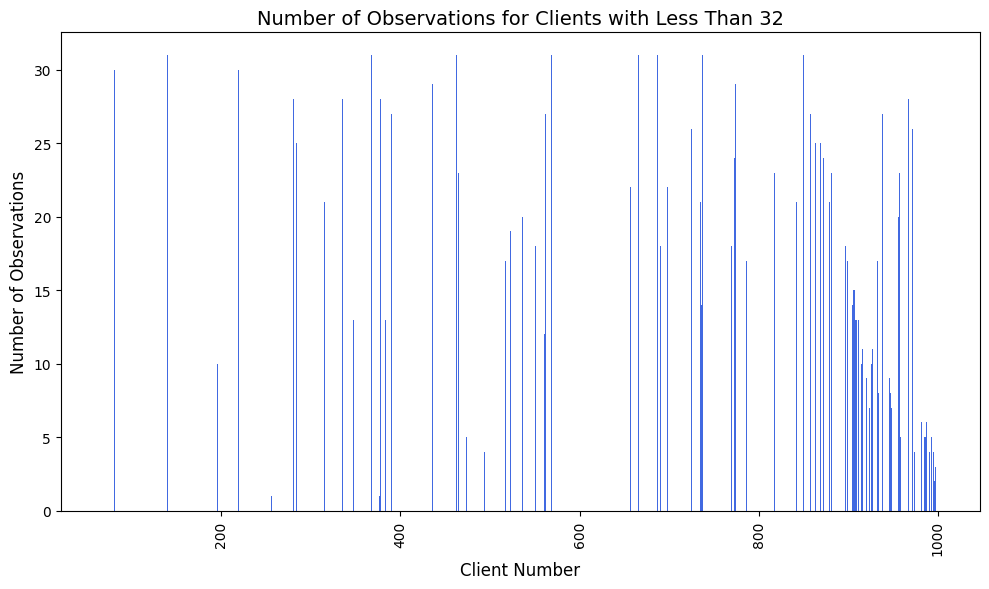

In [97]:
observation_counts = df_imputed['client_nr'].value_counts().reset_index()
observation_counts.columns = ['client_number', 'num_observations']

# Filter clients with less than 32 observations
filtered_df = observation_counts[observation_counts['num_observations'] < 32]
print(filtered_df.client_number.nunique())
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['client_number'], filtered_df['num_observations'])

# Customize the plot
plt.xlabel('Client Number', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)
plt.title('Number of Observations for Clients with Less Than 32', fontsize=14)
plt.xticks(rotation=90, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [82]:
# attach back  the target variable credit_application
df5['credit_application'] = df_imputed['credit_application']


In [83]:
df5[(df5['anomaly']==-1) & (df5['credit_application']==1)]

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,scores,anomaly,credit_application
70,3.0,201407.0,138.0,80.0,16424314.0,58.0,18660918.0,-50657408.0,-43590640.0,4.0,-0.040753,-1,1.0
81,3.0,201506.0,119.0,62.0,20268645.0,57.0,18085849.0,-50869752.0,-37022602.0,4.0,-0.040421,-1,1.0
87,3.0,201512.0,113.0,63.0,20967265.0,50.0,16562411.0,-50236785.0,-39779240.0,4.0,-0.040767,-1,1.0
95,3.0,201608.0,117.0,58.0,13198950.0,59.0,13238229.0,-54288785.0,-49699301.0,4.0,-0.055190,-1,1.0
172,6.0,201501.0,182.0,129.0,14650103.0,53.0,16878672.0,-29319663.0,3579881.0,7.0,-0.011536,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29576,975.0,201401.0,280.0,167.0,64473466.0,113.0,63621465.0,-37051268.0,26908185.0,2.0,-0.118655,-1,1.0
29600,975.0,201601.0,229.0,176.0,31322896.0,53.0,24106890.0,-10626213.0,12076283.0,2.0,-0.013776,-1,1.0
29603,975.0,201604.0,270.0,201.0,24172463.0,69.0,23094210.0,-12873012.0,3908083.0,2.0,-0.005055,-1,1.0
29702,979.0,201607.0,6.0,6.0,176851.0,0.0,0.0,-5683734.0,-5621237.0,7.0,-0.008323,-1,1.0


In [100]:
import pandas as pd
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np
import matplotlib.pyplot as plt



# Reshape data into a time-series format (pivot table)
time_series_data = df.pivot(index='client_nr', columns='yearmonth', values='credit_application').fillna(0).values

# Scale the data for K-Shape clustering
scaler = TimeSeriesScalerMeanVariance()
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Apply K-Shape clustering
kshape = KShape(n_clusters=3, random_state=42)
clusters_kshape = kshape.fit_predict(time_series_data_scaled)

# Add cluster labels back to the data
df_kshape = pd.DataFrame({'client_nr': df['client_nr'].unique(), 'cluster': clusters_kshape})
print("K-Shape Clustering Results:")
print(df_kshape)





K-Shape Clustering Results:
     client_nr  cluster
0            1        0
1            2        0
2            3        2
3            4        2
4            5        0
..         ...      ...
987        996        0
988        997        0
989        998        0
990        999        0
991       1000        0

[992 rows x 2 columns]


In [32]:
from scipy import stats

df[stats.zscore(df['total_nr_trx'])>3]['total_nr_trx'].count()


np.int64(271)

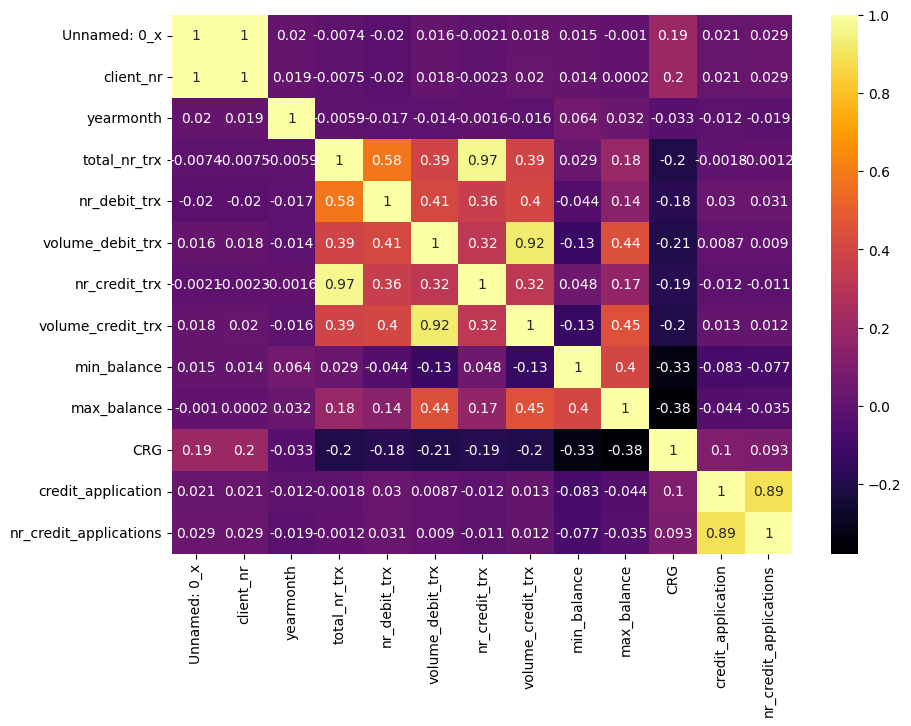

In [33]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='inferno');

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt


# Handle outliers
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

numeric_cols = Num_Features
data = cap_outliers(df, numeric_cols)

# Aggregate by client_nr
agg_funcs = ['mean', 'std', 'min', 'max', 'sum']
agg_data = data.groupby('client_nr').agg({col: agg_funcs for col in numeric_cols})
agg_data.columns = ['_'.join(col) for col in agg_data.columns]
agg_data['credit_application'] = df.groupby('client_nr')['credit_application'].first().values

# Train-test split
X = agg_data.drop(columns=['credit_application'])
y = agg_data['credit_application']



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the model
model = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
model.fit(X_train, y_train)

# Predictions and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")




AUC: 0.6639880952380952


In [40]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Train the model with balanced data
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)


model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

)



grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best AUC: {grid_search.best_score_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best AUC: 0.5864197530864197
Test AUC: 0.5610119047619048


In [20]:
df.columns

Index(['Unnamed: 0_x', 'client_nr', 'yearmonth', 'total_nr_trx',
       'nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx',
       'volume_credit_trx', 'min_balance', 'max_balance', 'CRG',
       'credit_application', 'nr_credit_applications'],
      dtype='object')

In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


# Separate features and target variable
X = df.drop(columns=['credit_application'])  # Replace 'credit_application' with your target column name
y = df['credit_application']

### 1. Handle Missing Values
# Replace missing values (NAs) with the median of each column
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

skewed_features = ['total_nr_trx',
     'volume_debit_trx', 
       'volume_credit_trx', 'min_balance', 'max_balance', 'CRG']  # List of skewed numeric feature names

### 2. Handle Skewed Distributions (Optional)
# Apply log transformation to positively skewed features (only if necessary)
#X_imputed[skewed_features] = X_imputed[skewed_features].applymap(lambda x: x if x > 0 else 1e-6)

# Create a custom FunctionTransformer for square root
#sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)

# Apply the transformation
#X_imputed[skewed_features] = sqrt_transformer.fit_transform(X_imputed[skewed_features])
### 3. Feature Selection Based on Distribution Overlaps
# Plot KDEs for visualization
# for col in X_imputed.columns:
#     plt.figure(figsize=(8, 4))
#     sns.kdeplot(data=X_imputed, x=col, hue=y, common_norm=False)
#     plt.title(f'Distribution of {col} by Target Variable')
#     plt.show()

# Remove low-importance or highly overlapping features manually after visual inspection
# You can replace with your own identified features
# X_selected = X_imputed.copy()
# ### 4. Check Multicollinearity
# # Compute correlation matrix
# corr_matrix = X_selected.corr()

# Drop one feature from each correlated pair based on your findings
features_to_drop = ['Unnamed: 0_x', 'nr_debit_trx', 'nr_credit_trx']  # Drop features with high correlations
X_selected = X.drop(columns=features_to_drop)


# Log the remaining features

### 5. Handle Class Imbalance
# Apply SMOTE after missing value imputation
# try:
#     smote = SMOTE(random_state=42)
#     X_resampled, y_resampled = smote.fit_resample(X_selected, y)
#     print("SMOTE applied successfully.")
# except ValueError as e:
#     print(f"SMOTE failed due to missing values: {e}")
#     print("Proceeding without SMOTE.")

# # Alternative: Use class weights in Random Forest if SMOTE fails
# class_weights = {0: 1, 1: y.value_counts()[0] / y.value_counts()[1]}

### 6. Train-Test Split
### 6. Train-Test Split
# Use y_resampled instead of y for stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

### 7. Train a Random Forest Classifier
clf = xgb.XGBClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5588
           1       1.00      1.00      1.00       412

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

